In [8]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import h5py

In [9]:
file = uproot.open("/N/project/phonon/PHONON_Bkgnds/shielded_250kneutrons_higherEprimary.root")

# Inspect the file to find available trees
#print(file.keys())

# Access a specific TTree (replace with actual tree name, e.g., "Events")
tree = file["Hits"]
tree2 = file["Primary"]

# List available branches
#print(tree.keys())

# Convert to a pandas DataFrame
# You can select specific branches or load all of them
df = tree.arrays(library="pd")

df2 = tree2.arrays(library="pd") # primary particle information

# Display the DataFrame
#print(df2.head())
print(df.head())

#convert the particle name to a string type instead of some "awkward" bytes type
df['ParticleName'] = df['ParticleName'].astype(str)
df['ParticleDefinition'] = df['ParticleDefinition'].astype(str)

#print(df.dtypes)
#df.info()

#access the file with no shielding in place

file2 = uproot.open("/N/project/phonon/PHONON_Bkgnds/no_shielded_250kneutrons_higherEprimary.root")

# Access the TTree
tree_no_shield = file2["Hits"]
tree2_no_shield = file2["Primary"]
# Convert to a pandas DataFrame
df_no_shield = tree_no_shield.arrays(library="pd")
df2_no_shield = tree2_no_shield.arrays(library="pd") # primary particle information

#convert the particle name to a string type instead of some "awkward" bytes type
df_no_shield['ParticleName'] = df_no_shield['ParticleName'].astype(str)
df_no_shield['ParticleDefinition'] = df_no_shield['ParticleDefinition'].astype(str)
#print(df_no_shield.dtypes)
#print(df_no_shield.info())


   EventID  TrackID       PDGCode  ParticleName  ParticleDefinition  \
0      4.0    963.0  1.000020e+09         alpha               alpha   
1      4.0    962.0  1.000010e+09        triton              triton   
2      4.0    961.0  1.000080e+09           O16                 O16   
3      5.0      9.0  1.000401e+09          Zr90                Zr90   
4      5.0      4.0  2.212000e+03        proton              proton   

           Edep  PositionX  PositionY  PositionZ   MomentumX  MomentumY  \
0  2.054620e+00  -2.231121  11.415623   8.065061    0.000000    0.00000   
1  2.726533e+00  -2.251836  11.401334   8.079872   -0.000000   -0.00000   
2  2.890495e-08  -1.751613  13.378512   4.241962    0.000000   -0.00000   
3  5.357425e-01   9.107504 -13.511767  18.526939    0.000000   -0.00000   
4  7.901242e+00  10.607785 -10.677111  20.000000  209.119054  379.59063   

   MomentumZ  MomentumDirectionX  MomentumDirectionY  MomentumDirectionZ  \
0   -0.00000            0.709425            0.

In [4]:
from typing import Dict, List, Optional, Iterable

def _to_series(arr: np.ndarray) -> pd.Series:
    if np.issubdtype(arr.dtype, np.bytes_):
        arr = arr.astype(str)
    try:
        return pd.Series(arr)
    except Exception:
        return pd.Series(arr, dtype=object)

def _collect_subgroup_datasets(
    g: h5py.Group,
    filter_substring: Optional[str] = None
) -> Dict[str, np.ndarray]:
    """
    Return {dataset_name: array} for datasets directly under group g.
    If filter_substring is provided, only include names containing it.
    """
    out = {}
    for k, v in g.items():
        if isinstance(v, h5py.Dataset):
            if filter_substring is None or filter_substring in k:
                out[k] = v[()]  # numpy array
    return out

def _list_immediate_subgroups(g: h5py.Group) -> List[str]:
    return [name for name, obj in g.items() if isinstance(obj, h5py.Group)]

def load_hits_with_subgroups(
    h5_path: str,
    ntuple_key: str = "default_ntuples",
    group_name: str = "Hits",
    filter_substring: Optional[str] = None,
    mode: str = "auto",  # "horizontal" | "vertical" | "auto"
    prefix_columns: bool = True
) -> pd.DataFrame:
    """
    Combine datasets from subgroups under .../<ntuple_key>/<group_name> into one DataFrame.
    Only datasets whose names contain filter_substring are selected (if provided).
    """
    base = f"{ntuple_key}/{group_name}"
    with h5py.File(h5_path, "r") as f:
        if base not in f or not isinstance(f[base], h5py.Group):
            raise KeyError(f"'{base}' not found or not a group")
        hits = f[base]

        subgroups = _list_immediate_subgroups(hits)
        if not subgroups:
            cols = _collect_subgroup_datasets(hits, filter_substring)
            if not cols:
                raise ValueError(f"No matching datasets found under '{base}'.")
            return pd.DataFrame({k: _to_series(v) for k, v in cols.items()})

        # Collect subgroup datasets and lengths
        per_group_data: Dict[str, Dict[str, np.ndarray]] = {}
        lengths: Dict[str, Optional[int]] = {}
        for sg in subgroups:
            g = hits[sg]
            data = _collect_subgroup_datasets(g, filter_substring)
            per_group_data[sg] = data
            if not data:
                lengths[sg] = None
            else:
                lens = {k: (len(v) if np.ndim(v) >= 1 else None) for k, v in data.items()}
                arr_lens = [L for L in lens.values() if L is not None]
                if len(arr_lens) > 0 and len(set(arr_lens)) == 1:
                    lengths[sg] = arr_lens[0]
                else:
                    lengths[sg] = None

        # Decide mode
        chosen_mode = mode
        if mode == "auto":
            valid = [L for L in lengths.values() if L is not None]
            if len(valid) == len(subgroups) and len(set(valid)) == 1:
                chosen_mode = "horizontal"
            else:
                chosen_mode = "vertical"

        if chosen_mode == "horizontal":
            n = next(iter(lengths.values()))
            if n is None:
                raise ValueError("Cannot combine horizontally — unequal or missing lengths.")
            cols: Dict[str, pd.Series] = {}
            for sg, data in per_group_data.items():
                for k, arr in data.items():
                    col_name = f"{sg}/{k}" if prefix_columns else k
                    if not prefix_columns and col_name in cols:
                        col_name = f"{sg}/{k}"
                    cols[col_name] = _to_series(arr)
            return pd.DataFrame(cols)

        elif chosen_mode == "vertical":
            frames = []
            for sg, data in per_group_data.items():
                if not data:
                    continue
                df_sg = pd.DataFrame({k: _to_series(v) for k, v in data.items()})
                df_sg["source_group"] = sg
                frames.append(df_sg)
            if not frames:
                raise ValueError(f"No matching datasets found in subgroups under '{base}'.")
            return pd.concat(frames, ignore_index=True, sort=True)

        else:
            raise ValueError("mode must be 'auto', 'horizontal', or 'vertical'")

In [6]:
#attempt to read an HDF5 file
file_path = "/N/project/phonon/PHONON_Bkgnds/shielded_hdf5test_higherEprimary.h5"
f = h5py.File(file_path, 'r')
print(list(f.keys()))
test = f['default_ntuples']
for name, obj in test.items():
        print(f"Object Name: {name}")
        if isinstance(obj, h5py.Group):
            print(f"  Type: Group")
        elif isinstance(obj, h5py.Dataset):
            print(f"  Type: Dataset, Shape: {obj.shape}, Dtype: {obj.dtype}")

# 2) Force horizontal merge (columns from every subgroup side-by-side)
df_h = load_hits_with_subgroups(
    file_path,
    ntuple_key="default_ntuples",
    group_name="Hits",
    filter_substring="pages",   # Only select datasets containing this text
    mode="auto"                 # Let it decide horizontal vs vertical
)
#df_hdf_test = pd.read_hdf("/N/project/phonon/PHONON_Bkgnds/shielded_hdf5test_higherEprimary.h5", key="default_ntuples")
print(df_h.head())
df_h['ParticleName/pages'] = df_h['ParticleName/pages'].astype(str)
df_h['ParticleDefinition/pages'] = df_h['ParticleDefinition/pages'].astype(str)


['default_histograms', 'default_ntuples', 'header']
Object Name: Hits
  Type: Group
Object Name: Primary
  Type: Group
     Edep/pages  EventID/pages  HitTime/pages  MomentumDirectionX/pages  \
0  2.054620e+00            4.0  317497.269837                  0.709425   
1  2.726533e+00            4.0  317497.271384                 -0.709409   
2  2.890495e-08            4.0  316043.663035                  0.556667   
3  5.357425e-01            5.0       4.991831                  0.337102   
4  7.901242e+00            5.0       5.017022                  0.439455   

   MomentumDirectionY/pages  MomentumDirectionZ/pages  MomentumX/pages  \
0                  0.489330                 -0.507219         0.000000   
1                 -0.489332                  0.507240        -0.000000   
2                 -0.691764                 -0.459983         0.000000   
3                 -0.899178                  0.279000         0.000000   
4                  0.797693                  0.412995       

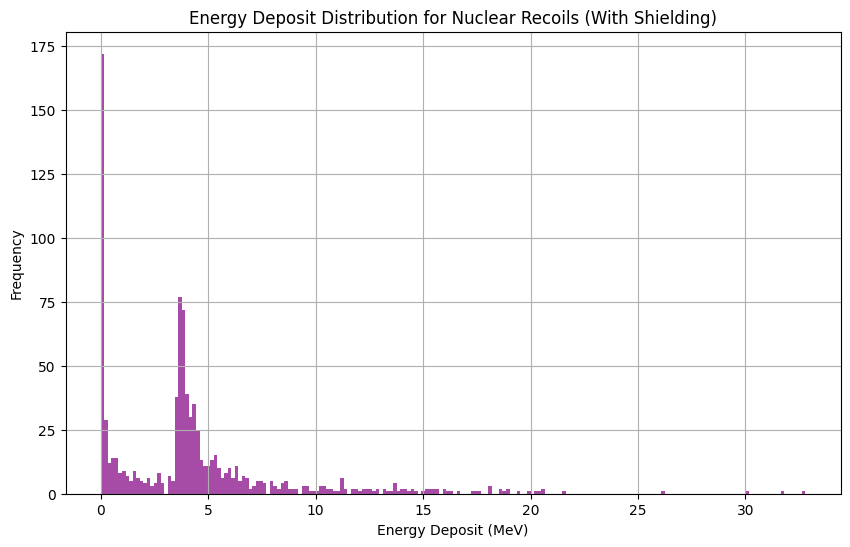

In [7]:
mask_nr = df_h['ParticleName/pages'].str.contains('Nb', case=False, na=True) | df_h['ParticleName/pages'].str.contains('Li', case=False, na=True)  | df_h['ParticleName/pages'].str.contains('O', case=False, na=True)  # Filter for Li, Nb, or O nuclear recoils
nr_df = df_h[mask_nr]
plt.figure(figsize=(10, 6))
plt.hist(nr_df['Edep/pages'], bins=200, color='purple', alpha=0.7)
plt.title('Energy Deposit Distribution for Nuclear Recoils (With Shielding)')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
plt.savefig("neutronsShielded_LiNbO3block_NRDistro_fromHDF5file.pdf")
plt.show()

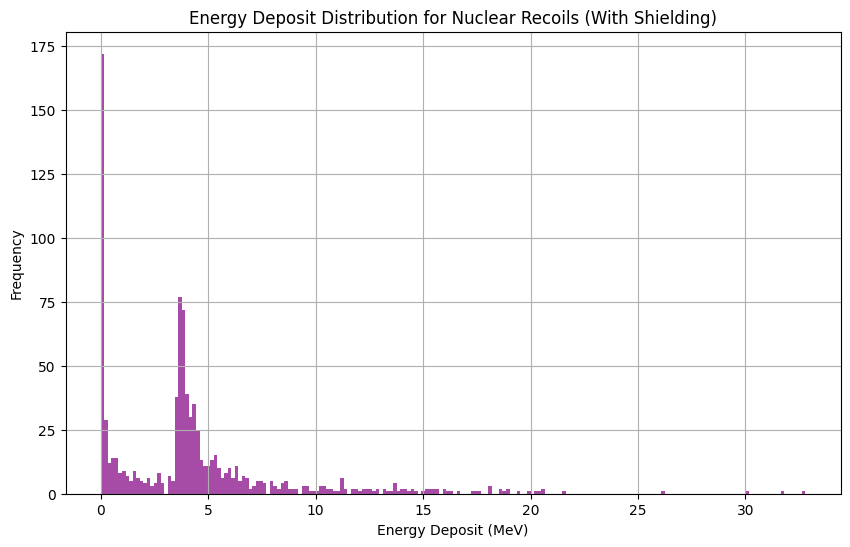

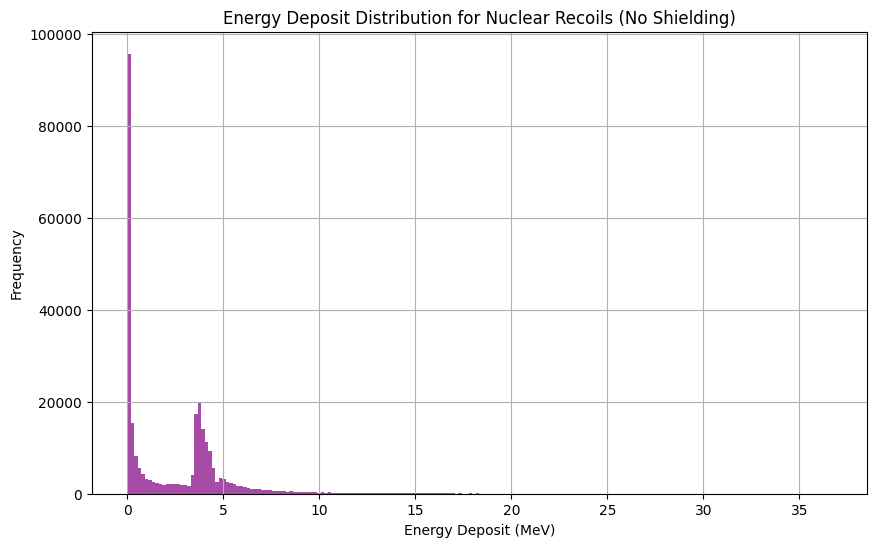

In [10]:
df.describe()  # Get a summary of the data
mask = df['Edep'] > 0  # Filter for positive energy deposits
mask2 = df['PDGCode'] == 11 # Filter for gamma or electrons
mask3 = df['PDGCode'] == 22 # Filter for gamma particles
mask4 = df['PDGCode'] == 2212 # Filter for protons
mask_nr = df['ParticleName'].str.contains('Nb', case=False, na=False) | df['ParticleName'].str.contains('Li', case=False, na=False)  | df['ParticleName'].str.contains('O', case=False, na=False)  # Filter for Li, Nb, or O nuclear recoils
el_gamma_df = df[mask2 | mask3]
proton_df = df[mask4]
no_ions_df = df[mask2 | mask3 | mask4]
nr_df = df[mask_nr]
'''
# Plotting the energy deposit distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Edep'], bins=200, color='blue', alpha=0.7)
plt.title('Full Energy Deposit Distribution')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
#plt.show()

# Plotting the energy deposit distribution for electrons and gammas
plt.figure(figsize=(10, 6))
plt.hist(el_gamma_df['Edep'], bins=200, color='green', alpha=0.7)
plt.title('Energy Deposit Distribution for Electrons and Gammas')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
#plt.show()

#plot the pdg code
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.hist(df['PDGCode'], bins=200, color='blue', alpha=0.7)
plt.title('PDG Code Distribution')
plt.xlabel('PDG Code')
plt.ylabel('Frequency')
plt.grid()
#plt.show()

#plot the pdg code for no ions
plt.figure(figsize=(10, 6))
plt.hist(no_ions_df['PDGCode'], bins=2500, color='orange', alpha=0.7)
plt.title('PDG Code Distribution for things other than ions')
plt.xlabel('PDG Code')
plt.ylabel('Frequency')
plt.grid()
#plt.show()  

# Plotting the energy deposit distribution for protons
plt.figure(figsize=(10, 6))
plt.hist(proton_df['Edep'], bins=200, color='red', alpha=0.7)
plt.title('Energy Deposit Distribution for Protons')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
#plt.show()
'''
# Plotting the energy deposit distribution for nuclear recoils
plt.figure(figsize=(10, 6))
plt.hist(nr_df['Edep'], bins=200, color='purple', alpha=0.7)
plt.title('Energy Deposit Distribution for Nuclear Recoils (With Shielding)')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
plt.savefig("scrap.pdf")
plt.show()

mask_nr_ns = df_no_shield['ParticleName'].str.contains('Nb', case=False, na=False) | df_no_shield['ParticleName'].str.contains('Li', case=False, na=False)  | df_no_shield['ParticleName'].str.contains('O', case=False, na=False)  # Filter for Li, Nb, or O nuclear recoils
nr_ns_df = df_no_shield[mask_nr_ns]
# Plotting the energy deposit distribution for nuclear recoils in no shielding
plt.figure(figsize=(10, 6))
plt.hist(nr_ns_df['Edep'], bins=200, color='purple', alpha=0.7)
plt.title('Energy Deposit Distribution for Nuclear Recoils (No Shielding)')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.grid()
plt.savefig("250kneutron_LiNbO3blockOnly_NRDistro.pdf")
plt.show()




    EventID  TrackID       PDGCode ParticleName ParticleDefinition      Edep  \
1      76.0      4.0  2.212000e+03       proton             proton  4.473974   
2      76.0      4.0  2.212000e+03       proton             proton  0.316226   
44    416.0   1262.0  1.000010e+09       triton             triton  2.725941   
46    432.0    131.0  1.000010e+09       triton             triton  2.726135   
62    450.0    693.0  1.000010e+09       triton             triton  2.726410   

    PositionX  PositionY  PositionZ  MomentumX  MomentumY  MomentumZ  \
1    6.759701 -16.081387  53.484919 -11.322203 -20.161292   7.670887   
2    6.758756 -16.083071  53.485560  -0.000000  -0.000000   0.000000   
44  17.399365  -5.621493  58.804499   0.000000   0.000000   0.000000   
46   9.851825  -6.346602  64.786263  -0.000000  -0.000000   0.000000   
62 -17.757195  17.623086  65.903742   0.000000   0.000000   0.000000   

    MomentumDirectionX  MomentumDirectionY  MomentumDirectionZ       HitTime  \
1     

/var/folders/kq/slrt63z96wxbf90zbfb8fpc40000gn/T/ipykernel_11313/19674903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nr_df["r^2"] = nr_df["PositionX"]**2 + nr_df["PositionY"]**2


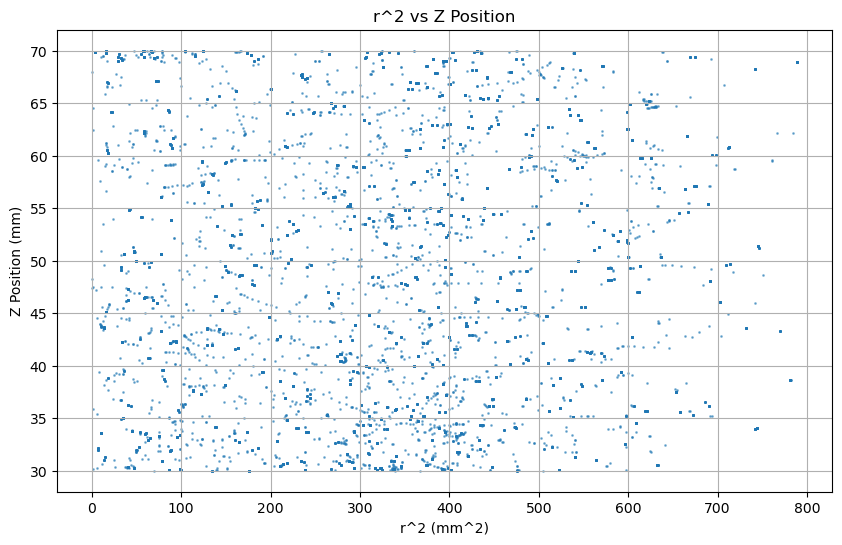

In [9]:

nr_df["r^2"] = nr_df["PositionX"]**2 + nr_df["PositionY"]**2
print(nr_df.head())
#masked_df = df[mask4]
#print(masked_df.head())
#plot the r^2 vs z distribution
plt.figure(figsize=(10, 6))
plt.scatter(df["r^2"], df["PositionZ"], alpha=0.5, s=1)
plt.title('r^2 vs Z Position')
plt.xlabel('r^2 (mm^2)')
plt.ylabel('Z Position (mm)')
plt.grid()
plt.show()


Fit parameters: a=-1.6066616208380666e-05, b=3.0260414218602387e-06, c=1.0000160665963203


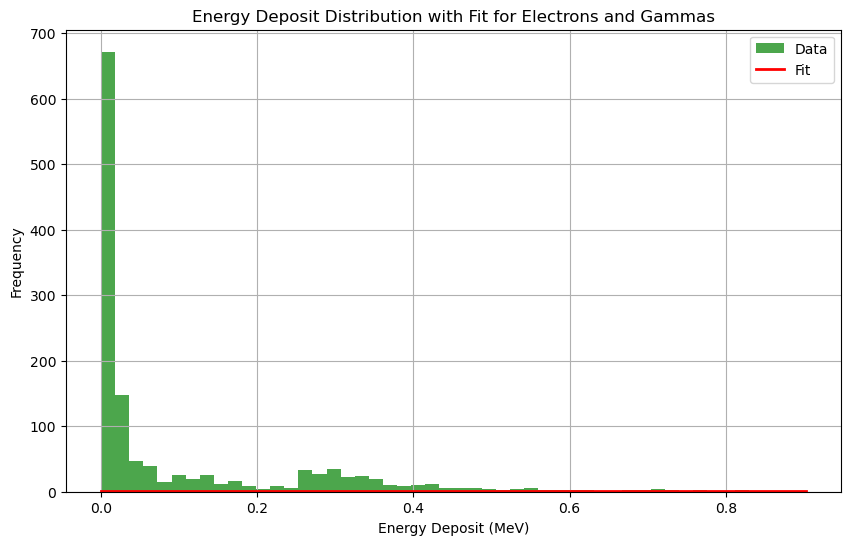

In [28]:
#define a fit function for the energy deposit distribution
def fit_function(x, a, b, c):
    return a * np.exp(-b * x) + c
# Fit the energy deposit distribution for electrons and gammas
from scipy.optimize import curve_fit
params, covariance = curve_fit(fit_function, df['Edep'], np.ones_like(df['Edep']), p0=[300, 1e-3, 0.1])
a, b, c = params    
print(f"Fit parameters: a={a}, b={b}, c={c}")
# Plot the fit
x_fit = np.linspace(0, el_gamma_df['Edep'].max(), 100)
y_fit = fit_function(x_fit, a, b, c)
plt.figure(figsize=(10, 6))
plt.hist(el_gamma_df['Edep'], bins=50, color='green', alpha=0.7, label='Data')
plt.plot(x_fit, y_fit, color='red', label='Fit', linewidth=2)
plt.title('Energy Deposit Distribution with Fit for Electrons and Gammas')
plt.xlabel('Energy Deposit (MeV)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()
            

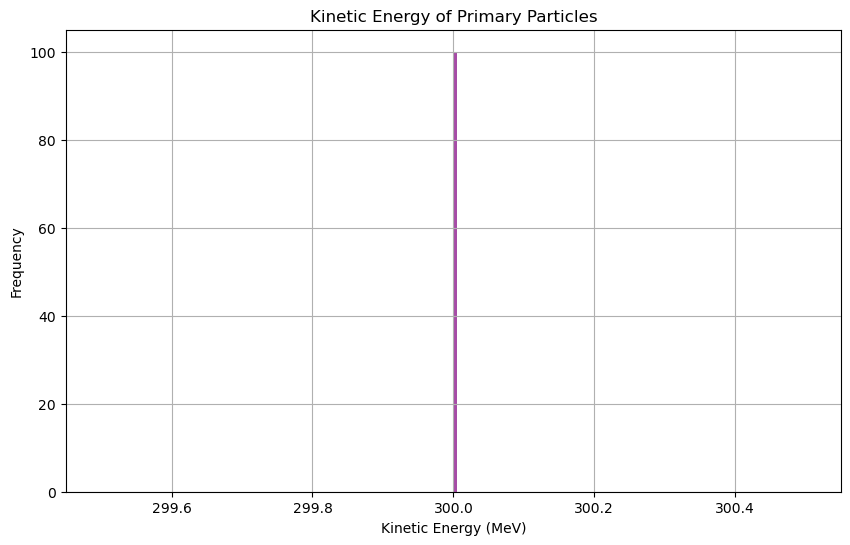

In [41]:
#plot the energy from the primary particles
plt.figure(figsize=(10, 6))
plt.hist(df2['PrimaryEnergy'], bins=200, color='purple', alpha=0.7)
plt.title('Kinetic Energy of Primary Particles')
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Frequency')             
plt.grid()
plt.show()